# **Simulaciones Monte Carlo**
El propósito de este proyecto es evaluar la viabilidad del método de simulación Monte Carlo en la valuación de opciones asiáticas aritméticas de compra (call) y venta (put) con vencimiento a seis meses, tomando como subyacente el tipo de cambio EUR/USD.
La metodología se centra en generar trayectorias del precio bajo el supuesto de un movimiento browniano geométrico (GBM), contrastando los resultados con las propiedades estadísticas observadas en los datos reales.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import anderson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import norm

## **Datos**
Se utilizó una muestra de 504 precios de cierre diarios correspondientes al tipo de cambio EUR/USD.  

Los precios históricos se obtuvieron de Yahoo Finance (ticker EURUSD=X). Estos corresponden a cotizaciones de mercado Forex, un mercado descentralizado, y el ‘precio de cierre’ refleja un valor de referencia diario (generalmente al final de la sesión de Nueva York).

Las observaciones abarcan un periodo de dos años, comprendido entre el 09/01/2024 y el 17/12/2025.  


In [18]:
fx=pd.read_csv("https://raw.githubusercontent.com/denilson-sl/Archivos/refs/heads/main/EUR-USD.csv")

In [19]:
#Preservamos únicamente las fechas y los precios de cierre del DataFrame original
fx.columns = ['Fecha', 'Cierre']
fx['Fecha'] = pd.to_datetime(fx['Fecha'])

#Cálculo de rendimientos simples y logarítmicos
fx['Rendimiento'] = fx['Cierre'].pct_change()
fx['R_log'] = np.log(fx['Cierre'] / fx['Cierre'].shift(1))
fx.drop(0, axis=0, inplace=True)
fx.reset_index(drop=True, inplace=True)
fx.head(5)


,Fecha,Cierre,Rendimiento,R_log
0,2024-01-09,1.095170,0.000865,0.000865
1,2024-01-10,1.093243,-0.001760,-0.001762
2,2024-01-11,1.097514,0.003907,0.003900
3,2024-01-12,1.098165,0.000593,0.000593
4,2024-01-15,1.094571,-0.003273,-0.003278


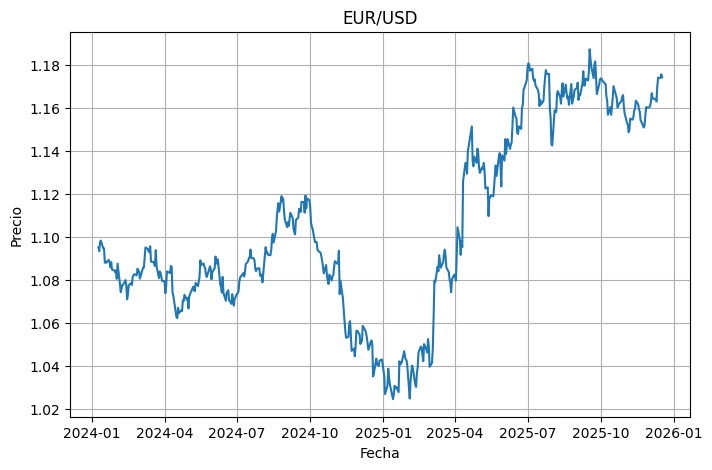

In [20]:
plt.figure(figsize=(8,5))
plt.plot(fx['Fecha'],fx['Cierre'])
plt.title('EUR/USD')
plt.ylabel('Precio')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

## **Comprobación de supuestos**
La valuación mediante simulaciones de Monte Carlo consiste en generar un gran número de trayectorias independientes entre sí sobre el precio del activo subyacente, suponiendo que este sigue un movimiento browniano geométrico (GBM). Para que dicho modelo sea válido, deben cumplirse las siguientes condiciones:
- Los rendimientos logarítmicos del activo son independientes y siguen una distribución normal.
- La varianza de los rendimientos permanece constante a lo largo del tiempo (supuesto de homocedasticidad).

Además, se contemplan los siguientes supuestos:

1.  El mercado es completo.
2.  No existen oportunidades de arbitraje.
3.  Probabilidad neutra al riesgo.
4.  No hay costos de transacción.
5.  Se pueden realizar compras y ventas en cualquier momento.
6.  La tasa libre de riesgo es constante.

### Normalidad de los rendimientos logarítmicos

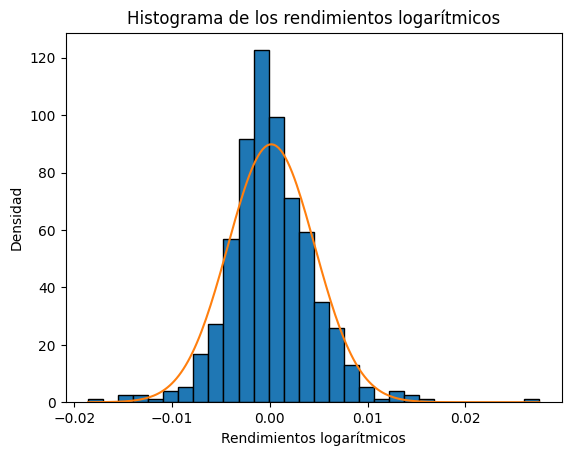

In [21]:
# Superposición del histograma de los rendimientos logarítmicos versus la distribución teórica normal

# Estimación de los parámetros de la distribución normal
mu = fx['R_log'].mean()
sigma = fx['R_log'].std()

# Rango de la gráfica
rango = np.linspace(fx['R_log'].min(), fx['R_log'].max(), 200)
pdf_normal = norm.pdf(rango, loc=mu, scale=sigma)

# Histograma
plt.hist(fx['R_log'], density=True, bins=30, edgecolor='Black')
plt.plot(rango, pdf_normal)
plt.title('Histograma de los rendimientos logarítmicos')
plt.xlabel('Rendimientos logarítmicos')
plt.ylabel('Densidad')
plt.show()


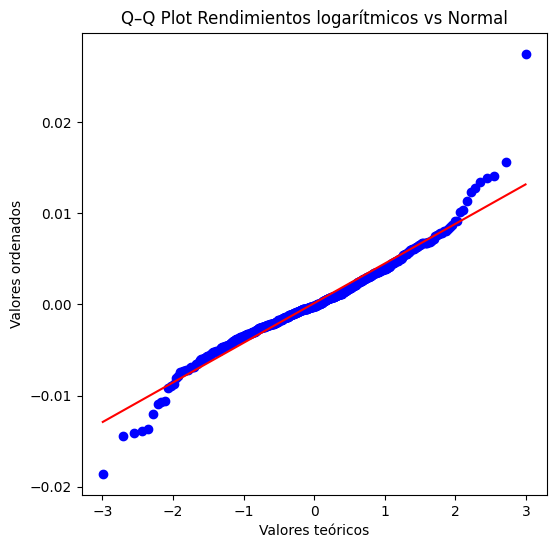

In [22]:
# Q-Q plot
plt.figure(figsize=(6,6))
stats.probplot(fx['R_log'], dist="norm", plot=plt)
plt.title("Q–Q Plot Rendimientos logarítmicos vs Normal")
plt.xlabel("Valores teóricos")
plt.ylabel("Valores ordenados")
plt.show()


In [23]:
# Prueba de bondad de ajuste (Anderson-Darling)
result = anderson(fx['R_log'], dist='norm')

print("Estadístico A²:", result.statistic)
print("Valores críticos:", result.critical_values)
print("Niveles de significancia (%):", result.significance_level)

Estadístico A²: 3.4394098696687365
Valores críticos: [0.572 0.651 0.781 0.911 1.084]
Niveles de significancia (%): [15.  10.   5.   2.5  1. ]


**Existe evidencia estadística suficiente para rechazar la hipótesis de normalidad en los rendimientos logarítmicos.** En presencia de colas pesadas, las trayectorias simuladas tienden a subestimar la probabilidad de que el precio del subyacente experimente cambios bruscos y en consecuencia no refleje adecuadamente la dinámica del activo, lo que puede derivar en una **subvaluación sistemática de instrumentos cuyo valor depende de eventos extremos**, particularmente en el caso de opciones muy out-of-the-money (OTM).

### Autocorrelación de los rendimientos logarítmicos

<Figure size 800x400 with 0 Axes>

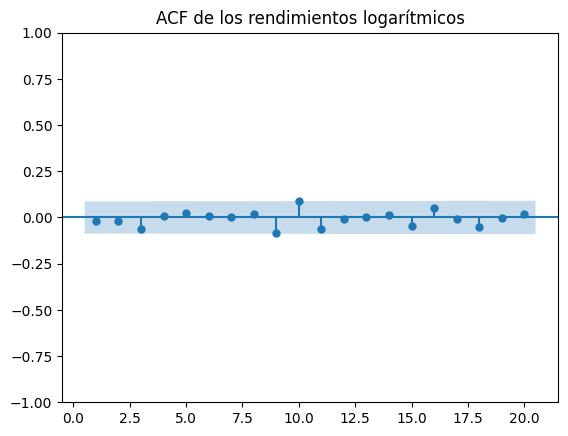

In [24]:
# ACF
plt.figure(figsize=(8,4))
plot_acf(fx['R_log'], lags=20, zero=False)
plt.title("ACF de los rendimientos logarítmicos")
plt.show()

### Varianza constante

<Figure size 800x400 with 0 Axes>

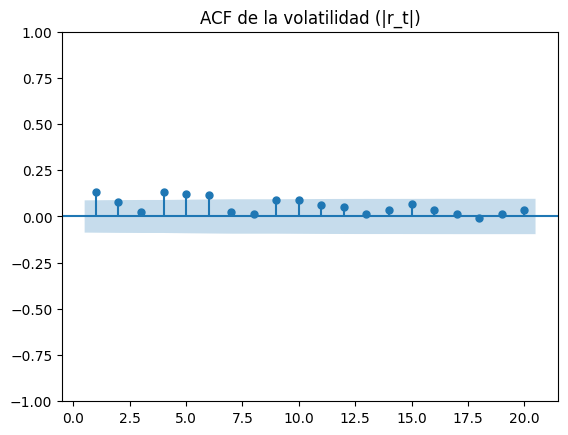

In [25]:
# ACF de la volatilidad (|r_t|)
abs_r = fx['R_log'].abs()

plt.figure(figsize=(8,4))
plot_acf(abs_r, lags=20, zero=False)
plt.title("ACF de la volatilidad (|r_t|)")
plt.show()

<Figure size 800x400 with 0 Axes>

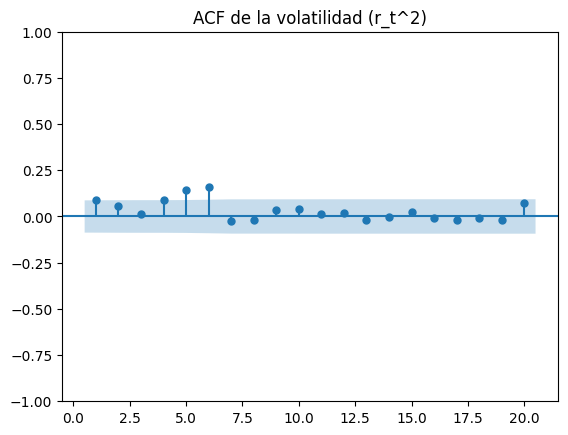

In [26]:
# ACF de la volatilidad (r_t^2)
r2 = fx['R_log']**2

plt.figure(figsize=(8,4))
plot_acf(r2, lags=20, zero=False)
plt.title("ACF de la volatilidad (r_t^2)")
plt.show()


In [27]:
# Prueba ARCH LM
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(fx['R_log'])

print("LM statistic:", lm_stat)
print("LM p-value:", lm_pvalue)
print("F-statistic:", f_stat)
print("F p-value:", f_pvalue)


LM statistic: 27.546232060414294
LM p-value: 0.0021330181004094837
F-statistic: 2.852336287034416
F p-value: 0.0018450396187982292


Media primer periodo: 7.427531170297371e-05
Media segundo periodo: 0.00017297255378232905
Media tercer periodo: 0.00017283699659598458
Volatilidad anualizada del primer periodo: 5.35%
Volatilidad anualizada del segundo periodo: 8.71%
Volatilidad anualizada del tercer periodo: 6.72%


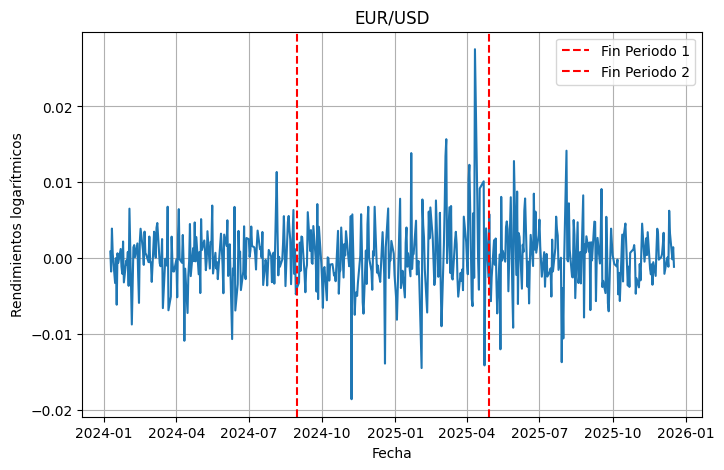

In [28]:
#Ánalisis por submuestra
# Se particiona la muestra en tres partes iguales
k = np.floor((fx['R_log'].count() / 3))
k = int(k)

#Se calcula la media y desviación de cada intervalo
mu1 = fx['R_log'][0:k+1].mean()
mu2 = fx['R_log'][k+1:2*k+2].mean()
mu3 = fx['R_log'][2*k+2:].mean()
sigma1 = fx['R_log'][0:k+1].std()*np.sqrt(252)*100
sigma2 = fx['R_log'][k+1:2*k+2].std()*np.sqrt(252)*100
sigma3 = fx['R_log'][2*k+2:].std()*np.sqrt(252)*100

print(f"Media primer periodo: {mu1}")
print(f"Media segundo periodo: {mu2}")
print(f"Media tercer periodo: {mu3}")
print(f"Volatilidad anualizada del primer periodo: {sigma1:.2f}%")
print(f"Volatilidad anualizada del segundo periodo: {sigma2:.2f}%")
print(f"Volatilidad anualizada del tercer periodo: {sigma3:.2f}%")

#Gráfica de los rendimientos logarítmicos
plt.figure(figsize=(8,5))
plt.plot(fx['Fecha'], fx['R_log'])
plt.title('EUR/USD')
plt.ylabel('Rendimientos logarítmicos')
plt.xlabel('Fecha')

# Líneas verticales de las particiones
linea_1 = fx['Fecha'].iloc[k]
linea_2 = fx['Fecha'].iloc[2*k+1]

plt.axvline(x=linea_1, color='red', linestyle='--', label='Fin Periodo 1')
plt.axvline(x=linea_2, color='red', linestyle='--', label='Fin Periodo 2')

plt.grid(True)
plt.legend()
plt.show()

**Los datos presentan evidencia estadística de heterocedasticidad condicional, lo que implica que la varianza no permanece constante, sino que depende de la volatilidad observada en periodos anteriores.** En este contexto, la presencia de clusters de volatilidad provoca que los precios generados por el modelo no representen fielmente los precios reales, dado que la volatilidad implícita no necesariamente coincide con la volatilidad asumida en la simulación.


## **Valuación**

### Movimiento Browniano Geométrico (GBM)

El precio del activo subyacente $S_t$ se modela mediante un **movimiento browniano geométrico**. Bajo la medida neutral al riesgo, su ecuación diferencial estocástica está dada por:

$$
\mathrm{d}S_t = r\,S_t\,\mathrm{d}t + \sigma\,S_t\,\mathrm{d}W_t,
$$

donde:
- $S_t$ es el precio del activo en el tiempo $t$,
- $r$ es la tasa libre de riesgo constante,
- $\sigma$ es la volatilidad constante,
- $W_t$ es un movimiento browniano estándar.


## Discretización para simulación Monte Carlo

Al discretizar el proceso en intervalos de tiempo de tamaño $\Delta t$, la evolución del precio se expresa como:

$$
S_{t+\Delta t} = S_t \exp\left[\left(r - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \sqrt{\Delta t}\, Z_t \right],
$$

donde:
- $Z_t \sim \mathcal{N}(0,1)$ son variables aleatorias independientes,
- $\Delta t$ representa el tamaño del paso temporal.

Para efectos del presente proyecto,
$$
r = r_d - r_f
$$

donde:
- $r_d$ es la tasa libre de riesgo doméstica (USD),
- $r_f$ es la tasa libre de riesgo extranjera (EUR),

específicamente:
- $r_d$ = 3,59922% (SOFR a 6 meses)

- $r_f$ = 2.126% (Euribor a 6 meses)



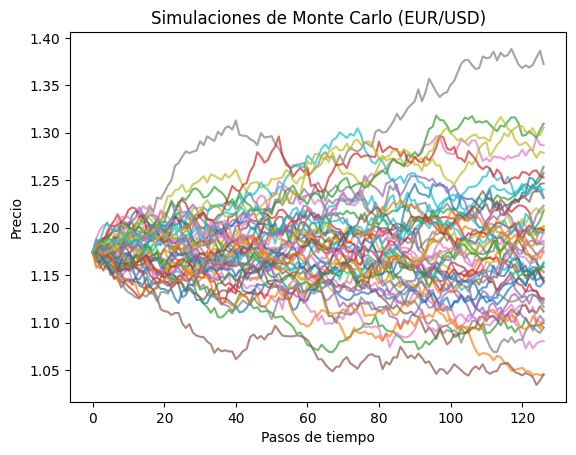

In [29]:
#Parámetros
r_d = 0.0359922
r_f = 0.02126
K = 1.10
n_trayectorias = 10_000
S_0 = fx['Cierre'].iloc[-1]                    #Último precio disponible
sigma=fx['R_log'][-252:].std()*np.sqrt(252)    #Volatilidad anual del último año
T = 0.5                                        #Opción a seis meses de vencimiento

#Discretización
n_pasos = int(252/2)
dt = T / n_pasos

#Semilla para que el experimento sea reproducible
np.random.seed(123)

# Simulación Monte Carlo
Z = np.random.randn(n_pasos, n_trayectorias)  #Matriz (n_pasos)x(n_trayectorias) donde cada entrada es un valor aleatorio de una N(0,1)
S = np.zeros((n_pasos + 1, n_trayectorias))   #Matriz (n_pasos + 1)x(n_trayectorias) donde la primera entrada para todas las trayectorias es S_0
S[0, :] = S_0

for t in range(1, n_pasos + 1):
    #Por cada fila (paso) se calcula el valor de todas las columnas (trayectorias)
    S[t, :] = S[t-1, :] * np.exp((r_d - r_f - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1, :])


# Gráfica con las primeras 50 trayectorias

n_trayectorias_grafica = 50
plt.figure()

# 50 trayectorias
plt.plot(S[:, :n_trayectorias_grafica], alpha=0.7)
plt.xlabel("Pasos de tiempo")
plt.ylabel("Precio")
plt.title("Simulaciones de Monte Carlo (EUR/USD)")
plt.show()

In [30]:
# Payoff asiático aritmético
S_promedio = S[1:, :].mean(axis=0)               #Vector con el precio promedio de cada trayectoria sin considerar el precio inicial

#Vectores con los payoffs de cada trayectoria de una opción call y put respectivamente
payoff_call = np.maximum(S_promedio - K, 0)
payoff_put = np.maximum(K - S_promedio, 0)

#Precio del derivado
precio_call = payoff_call.mean() * np.exp(-r_d * T)
precio_put = payoff_put.mean()* np.exp(-r_d * T)

#Error estándar del estimador
error_call = np.exp(-r_d * T) * payoff_call.std(ddof=1) / np.sqrt(n_trayectorias)
error_put = np.exp(-r_d * T) * payoff_put.std(ddof=1) / np.sqrt(n_trayectorias)

# Intervalo de confianza al 95% del valor "real" del derviado
z_95 = 1.96

call_inf = precio_call - z_95 * error_call
call_sup = precio_call + z_95 * error_call

put_inf = precio_put - z_95 * error_put
put_sup = precio_put + z_95 * error_put

print("===== OPCIÓN ASIÁTICA ARITMÉTICA =====\n")

print("CALL:")
print(f"Precio estimado      : {precio_call:.6f}")
print(f"Error estándar (MC)  : {error_call:.6f}")
print(f"IC 95%               : [{call_inf:.6f}, {call_sup:.6f}]\n")

print("PUT:")
print(f"Precio estimado      : {precio_put:.6f}")
print(f"Error estándar (MC)  : {error_put:.6f}")
print(f"IC 95%               : [{put_inf:.6f}, {put_sup:.6f}]")



===== OPCIÓN ASIÁTICA ARITMÉTICA =====

CALL:
Precio estimado      : 0.077510
Error estándar (MC)  : 0.000372
IC 95%               : [0.076781, 0.078239]

PUT:
Precio estimado      : 0.000224
Error estándar (MC)  : 0.000022
IC 95%               : [0.000180, 0.000268]


## **Conclusión**
El análisis estadístico de los datos históricos del tipo de cambio EUR/USD revela que los supuestos fundamentales del GBM no se cumplen:
- Los rendimientos **no siguen una distribución normal**, presentando colas pesadas.
- Existe **heterocedasticidad condicional**.
- La volatilidad **no es constante en el tiempo** y muestra clustering.

En consecuencia, cualquier técnica de reducción de varianza aplicada sobre este modelo (como el uso de variables de control) no resolvería el problema de fondo: la especificación incorrecta de la dinámica del subyacente.
Por ello, se considera más adecuado explorar modelos alternativos que capturen de manera explícita la volatilidad condicional y la presencia de clusters. En particular, los modelos de la familia **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity).

## **Acciones recomendadas**
Con el fin de fortalecer la validez del modelo de valuación, el proyecto evoluciona hacia una segunda etapa en la que se busca:
- Implementar un modelo **GARCH** para describir la dinámica de los rendimientos.
- Generar trayectorias simuladas bajo este esquema y evaluar nuevamente las opciones.
